In [25]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [22]:
# storing 
import numpy as np
import pandas as pd
import calmap
import warnings
import itertools
import wget
import os
import shutil
import datetime
import matplotlib.ticker as plticker
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU, WeekdayLocator
from scipy.fftpack import fft
from scipy.signal import butter, lfilter, freqz, stft
warnings.filterwarnings('ignore')
dataPath = '../data/'
pd.set_option('display.max_columns', None)
from IPython.display import HTML

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#### 0. Functions
- Run below cell once

In [106]:
{
    "tags": [
        "hide_input",
    ]
}

def Update_Data():
    urls = ['https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv', 
            'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv']

    for url in urls:
        filename = wget.download(url)
        os.remove(dataPath + filename)
        newPath = shutil.move(filename, dataPath[0:-1])
        
    conf_df = pd.read_csv(dataPath + 'time_series_covid19_confirmed_global.csv')
    deaths_df = pd.read_csv(dataPath + 'time_series_covid19_deaths_global.csv') 
    
    return conf_df, deaths_df

# -------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Creates a row for each individual country: (Aggregates)
def create_aggregates_dataframe(df):
    province_states_unique = df["Province/State"].unique()#.dropna().unique()
    dfAggregates = df[df['Province/State'].isin(province_states_unique)]
    country_region_aggregates = dfAggregates['Country/Region'].unique()

    for i, agg_country in enumerate(country_region_aggregates):
        lstRow = []
        dfTemp = dfAggregates[dfAggregates['Country/Region'] == agg_country]
        provState = agg_country + '_Total'                             # Countries with the sum of their states
        lat = dfTemp.Lat.sum()/len(dfTemp)                             # i.e. Australia with Victoria, NSW etc aggregated
        long = dfTemp.Long.sum()/len(dfTemp)
        rowEntries = [provState, agg_country, lat, long]
        lstRow = [elem for elem in rowEntries] 
        for col in dfTemp.columns[4:]:
            col_j_aggregate = dfTemp[col].sum()
            lstRow.append(col_j_aggregate)
        lstRow = pd.DataFrame([lstRow], columns = dfTemp.columns)
        df = df.append(lstRow)
        
    df_list = []
    for i, agg_country in enumerate(country_region_aggregates):    
        country_df = df[df['Country/Region'] == agg_country]
        uniqueProvs = country_df['Province/State'].unique()
        country_df = country_df[(country_df['Province/State'].isnull()) | (country_df['Province/State'].str.contains('_Total'))]
        if len(country_df) > 1:
            #country_df.drop([country + '_Total'], axis = 0, inplace = True)
            country_df = country_df[country_df['Province/State'] != agg_country + '_Total']
        df_list.append(country_df)
    df = pd.concat(df_list)
    df.drop(['Province/State'], axis = 1, inplace = True)
    return df
        
def create_changes_dataframe(df):
    
    province_states_unique = df["Province/State"].unique()#.dropna().unique()
    dfAggregates = df[df['Province/State'].isin(province_states_unique)]
    country_region_aggregates = dfAggregates['Country/Region'].unique()
    
    # STEP_1:
    # Some countries have individual states listed: Aggregate state-values together to gain actual country values
    for i, agg_country in enumerate(country_region_aggregates):
        lstRow = []
        dfTemp = dfAggregates[dfAggregates['Country/Region'] == agg_country]
        if len(dfTemp) > 1:
            provState = agg_country + '_Total'         # Countries with the sum of their states
            lat = dfTemp.Lat.sum()/len(dfTemp)         # i.e. Australia with Victoria, NSW etc aggregated
            long = dfTemp.Long.sum()/len(dfTemp)
            rowEntries = [provState, agg_country, lat, long]
            lstRow = [elem for elem in rowEntries] 
            for col in dfTemp.columns[4:]:
                col_j_aggregate = dfTemp[col].sum()
                lstRow.append(col_j_aggregate)
            lstRow = pd.DataFrame([lstRow], columns = dfTemp.columns)
            df = df.append(lstRow)
    
    df = df.sort_values(by = "Country/Region") 
    df['Province/State'].fillna(df['Country/Region'], inplace=True)  # Countries not including their colonial states
    df = df.reset_index(drop = True)                                 # i.e. United Kingdom without the "Falkland Islands"
    
    # STEP_2:
    # Make new columns to represent daily changes and convert US date-format to dd/mm/yy
    col_list = df.columns[0:4].tolist()
    for col in df.columns[4:]:
        if len(col) == 8: 
            col = "Diff_Prev_Day_" + col[3:5] + col[2] + col[0:2] # i.e. '12/12/20'
        elif len(col) == 7:
            col = "Diff_Prev_Day_" + col[2:4] + col[1] + col[0] # i.e.   '2/12/20'
        elif len(col) == 6:
            col = "Diff_Prev_Day_" + col[2:3] + col[1] + col[0] # i.e.   '2/2/20'
        col_list.append(col)
        
    ## STEP_3:
    # Define new dataframe to represent daily changes
    df_daily_change = pd.DataFrame(columns = col_list)
    countries_unique = df["Country/Region"].unique()
    growth_rates = []
    prevNum = 0
    len_max = len(df.columns[4:])
    
    ## STEP_4:
    # a) Iterate through each country and respective regions:
    for country in countries_unique:       
        df_country = df[df["Country/Region"] == country]
        province_states_unique = df_country["Province/State"].dropna()

        for province_state in province_states_unique:

            # b) Start dataframe recording from first registered case: (ignore all prior zero-cases on earlier dates)
            df_province_state = df_country[df_country["Province/State"] == province_state]
            df_province_state = df_province_state.loc[:, (df_province_state != 0).any(axis=0)]
            
            # d) Save first four columns (Province, Country, Lat, Long)
            #    Determine how many days prior to first case recorded (pad with 0)
            day_change_lst = df_province_state[df_province_state.columns[0:4]].values[0].tolist() 
            diff = len_max - len(df_province_state.columns[4:])
            day_change_lst += [0] * (diff) 
     
            
            # e) Calculate change from one-day to the next
            totalCases = 0
            for col in df_province_state.columns[4:]:
                new_num_cases = df_province_state[col].values[0]
                change_cases = new_num_cases - totalCases
                #if change_cases < 0:
                #    change_cases = 0
                totalCases = new_num_cases
                day_change_lst.append(change_cases)

            df_day_i_change = pd.DataFrame([day_change_lst], columns = col_list)

            if len(df_daily_change) == 0:
                df_daily_change = df_day_i_change
            else:
                df_daily_change = pd.concat([df_daily_change, df_day_i_change])
    
    return df_daily_change

# -------------------------------------------------------------------------------------------------------------------------------------------------------------------

def plotDailyChanges(df, list_countries, colourList, axislabels, filterInputs, plotAbsoluteCases = False):
    
    filtering = filterInputs[0]
    Ts = filterInputs[1]
    order = filterInputs[2]
    cutoff = filterInputs[3]
    
    f = plt.figure(figsize=(20,10))
    ax = f.add_subplot("111")
    
    if plotAbsoluteCases:
        for i, country in enumerate(list_countries):
            df_ = df[df['Country/Region'] == country]
            x = df_.columns[3:].tolist()
            y = df_[df_.columns[3:]].values.tolist()[0]
            plt.plot(x, y, '<-', label = country)
            plt.legend()
        plt.xticks(rotation=45)
        plt.ylabel(axislabels[0], size = 15)
        plt.xlabel("Date", size = 15)
        loc = plticker.MultipleLocator(base=5.0) # this locator puts ticks at regular intervals
        ax.xaxis.set_major_locator(loc)
        return
            
    else:
        df_plot = pd.DataFrame()
        base = datetime.date(2020, 1, 22)
        numdays = len(df.columns[4:])
        date_list = [base + datetime.timedelta(days=x) for x in range(numdays)]
        province_states_unique = df["Province/State"].unique()
        inputVariable = "DayChanges"
        j = 0
        for province_state in province_states_unique:
            df_province_state = df[df["Province/State"] == province_state]
            dayChanges = df_province_state[df_province_state.columns[4:]].values[0]

            if max(dayChanges) > 0 and (province_state in list_countries):
                #j += 1
                if j%1 == 0:
                    colour = colourList[j]
                    j += 1
                    df_plot["dates"] = date_list
                    df_plot["DayChanges"] = dayChanges
                    #df_plot["growth_rates"] = df_plot["growth_rates"].rolling(3).mean()
                    if filtering:
                        y_filtered = lowPass_butterworth(df_plot, inputVariable, cutoff, order, Ts)
                        df_plot["y_filtered"] = y_filtered
                        df_plot["y_filtered"] = df_plot["y_filtered"].rolling(3).mean()
                        if j%2 == 0:
                            plt.bar(df_plot.dates,  df_plot["y_filtered"], color = colour, label = province_state, linewidth = 1, alpha = 0.2)
                        else:
                            plt.bar(df_plot.dates,  df_plot["y_filtered"], color = colour, label = province_state, linewidth = 1, alpha = 0.2)
                    else:
                         plt.plot(df_plot.dates, df_plot.DayChanges, "-o", color = colour, label = province_state, linewidth = 1, alpha = 0.2)

            #break
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    #import matplotlib.dates.WeekdayLocator
    # tick on mondays every week
    #loc = WeekdayLocator(byweekday=MO, tz=tz)

    # tick on mondays and saturdays
    loc = WeekdayLocator(byweekday=(MO,FR))
    ax.xaxis.set_major_locator(loc)
    plt.xticks(rotation=45)
    plt.ylabel(axislabels[0], size = 15)
    plt.xlabel("Date", size = 15)
    #plt.xlim(df_plot.dates[15], df_plot.dates[len(df_plot.dates) - 1])
    plt.gca().set_xlim(left=df_plot.dates[20])
    plt.title(axislabels[1], size = 20)
    #plt.ylim([-1, 100])
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.show()
    

# -------------------------------------------------------------------------------------------------------------------------------------------------------------------

def getcolour():
    return np.random.rand(3,)

# -------------------------------------------------------------------------------------------------------------------------------------------------------------------

def lowPass_butterworth(io_signal, inputVariable, cutoff, order, Ts):
    #### Try cut-off frequency of cutoff units

    # Signal
    variable = inputVariable #+ str(gainNum) 
    
    # Detrend
    y = io_signal[variable].dropna() - (io_signal[variable].dropna()).sum() / len(io_signal[variable].dropna())
    #print(y[0:5])
    # Sample-rate
    fs = 1 / Ts
    #print(fs)
    # Low-pass calculation
    b, a = butter_lowpass(cutoff, fs, order=order)
    y_butter = lfilter(b, a, y) + (io_signal[variable].dropna()).sum() / len(io_signal[variable].dropna())
    offset = min(y.dropna().index.values)

    #brewCycle = np.linspace(0, brew_curr.BrwDurationSec.dropna(), len(brew_curr.BrwDurationSec.dropna()), endpoint=False)
    #sample = np.linspace(offset, len(y_butter) + offset, len(y_butter), endpoint=False)
    
    return y_butter

# -------------------------------------------------------------------------------------------------------------------------------------------------------------------

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# ---------------------------------------------------------------------------------------------------------------------

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def create_changes_dataframe_(df):
    
    province_states_unique = df["Province/State"].unique()#.dropna().unique()
    dfAggregates = df[df['Province/State'].isin(province_states_unique)]
    country_region_aggregates = dfAggregates['Country/Region'].unique()

    for i, agg_country in enumerate(country_region_aggregates):
        lstRow = []
        dfTemp = dfAggregates[dfAggregates['Country/Region'] == agg_country]
        if len(dfTemp) > 1:
            provState = agg_country + '_Total'          # Countries with the sum of their states
            lat = dfTemp.Lat.sum()/len(dfTemp)          # i.e. Australia with Victoria, NSW etc aggregated
            long = dfTemp.Long.sum()/len(dfTemp)
            rowEntries = [provState, agg_country, lat, long]
            lstRow = [elem for elem in rowEntries] 
            for col in dfTemp.columns[4:]:
                col_j_aggregate = dfTemp[col].sum()
                lstRow.append(col_j_aggregate)
            lstRow = pd.DataFrame([lstRow], columns = dfTemp.columns)
            df = df.append(lstRow)
    
    df = df.sort_values(by = "Country/Region") 
    df['Province/State'].fillna(df['Country/Region'], inplace=True) # Countries not including their colonial states
    df = df.reset_index(drop = True)                                # i.e. United Kingdom without the "Falkland Islands"

    return df

In [103]:
df_daily_change_conf = create_changes_dataframe(conf_df)

In [93]:
df_daily_change_conf[df_daily_change_conf['Country/Region'] == 'Spain'].head()

,Province/State,Country/Region,Lat,Long,Diff_Prev_Day_22/1,Diff_Prev_Day_23/1,Diff_Prev_Day_24/1,Diff_Prev_Day_25/1,Diff_Prev_Day_26/1,Diff_Prev_Day_27/1,Diff_Prev_Day_28/1,Diff_Prev_Day_29/1,Diff_Prev_Day_30/1,Diff_Prev_Day_31/1,Diff_Prev_Day_1/2,Diff_Prev_Day_2/2,Diff_Prev_Day_3/2,Diff_Prev_Day_4/2,Diff_Prev_Day_5/2,Diff_Prev_Day_6/2,Diff_Prev_Day_7/2,Diff_Prev_Day_8/2,Diff_Prev_Day_9/2,Diff_Prev_Day_10/2,Diff_Prev_Day_11/2,Diff_Prev_Day_12/2,Diff_Prev_Day_13/2,Diff_Prev_Day_14/2,Diff_Prev_Day_15/2,Diff_Prev_Day_16/2,Diff_Prev_Day_17/2,Diff_Prev_Day_18/2,Diff_Prev_Day_19/2,Diff_Prev_Day_20/2,Diff_Prev_Day_21/2,Diff_Prev_Day_22/2,Diff_Prev_Day_23/2,Diff_Prev_Day_24/2,Diff_Prev_Day_25/2,Diff_Prev_Day_26/2,Diff_Prev_Day_27/2,Diff_Prev_Day_28/2,Diff_Prev_Day_29/2,Diff_Prev_Day_1/3,Diff_Prev_Day_2/3,Diff_Prev_Day_3/3,Diff_Prev_Day_4/3,Diff_Prev_Day_5/3,Diff_Prev_Day_6/3,Diff_Prev_Day_7/3,Diff_Prev_Day_8/3,Diff_Prev_Day_9/3,Diff_Prev_Day_10/3,Diff_Prev_Day_11/3,Diff_Prev_Day_12/3,Diff_Prev_Day_13/3,Diff_Prev_Day_14/3,Diff_Prev_Day_15/3,Diff_Prev_Day_16/3,Diff_Prev_Day_17/3,Diff_Prev_Day_18/3,Diff_Prev_Day_19/3,Diff_Prev_Day_20/3,Diff_Prev_Day_21/3,Diff_Prev_Day_22/3,Diff_Prev_Day_23/3,Diff_Prev_Day_24/3,Diff_Prev_Day_25/3,Diff_Prev_Day_26/3,Diff_Prev_Day_27/3,Diff_Prev_Day_28/3,Diff_Prev_Day_29/3,Diff_Prev_Day_30/3,Diff_Prev_Day_31/3,Diff_Prev_Day_1/4,Diff_Prev_Day_2/4,Diff_Prev_Day_3/4,Diff_Prev_Day_4/4,Diff_Prev_Day_5/4,Diff_Prev_Day_6/4,Diff_Prev_Day_7/4,Diff_Prev_Day_8/4,Diff_Prev_Day_9/4,Diff_Prev_Day_10/4,Diff_Prev_Day_11/4,Diff_Prev_Day_12/4,Diff_Prev_Day_13/4,Diff_Prev_Day_14/4,Diff_Prev_Day_15/4,Diff_Prev_Day_16/4,Diff_Prev_Day_17/4,Diff_Prev_Day_18/4,Diff_Prev_Day_19/4,Diff_Prev_Day_20/4,Diff_Prev_Day_21/4,Diff_Prev_Day_22/4,Diff_Prev_Day_23/4,Diff_Prev_Day_24/4,Diff_Prev_Day_25/4,Diff_Prev_Day_26/4,Diff_Prev_Day_27/4,Diff_Prev_Day_28/4,Diff_Prev_Day_29/4,Diff_Prev_Day_30/4,Diff_Prev_Day_1/5,Diff_Prev_Day_2/5,Diff_Prev_Day_3/5,Diff_Prev_Day_4/5,Diff_Prev_Day_5/5,Diff_Prev_Day_6/5,Diff_Prev_Day_7/5,Diff_Prev_Day_8/5,Diff_Prev_Day_9/5,Diff_Prev_Day_10/5,Diff_Prev_Day_11/5,Diff_Prev_Day_12/5,Diff_Prev_Day_13/5,Diff_Prev_Day_14/5,Diff_Prev_Day_15/5,Diff_Prev_Day_16/5,Diff_Prev_Day_17/5,Diff_Prev_Day_18/5,Diff_Prev_Day_19/5,Diff_Prev_Day_20/5,Diff_Prev_Day_21/5,Diff_Prev_Day_22/5,Diff_Prev_Day_23/5,Diff_Prev_Day_24/5,Diff_Prev_Day_25/5,Diff_Prev_Day_26/5,Diff_Prev_Day_27/5
0,Spain,Spain,40.0,-4.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,7,2,17,13,39,36,45,57,37,141,100,173,400,622,582,0,2955,1159,1407,2144,1806,2162,4053,2447,4964,3394,6368,4749,9630,8271,7933,7516,6875,7846,7967,8195,7947,7134,6969,5478,5029,5267,6278,5002,5051,4754,3804,3268,2442,5103,7304,5891,887,6948,1536,3968,4211,4635,-10034,2915,1729,1831,1308,2144,518,1781,1366,884,545,1318,996,1122,1410,721,772,3086,594,661,849,643,515,0,908,431,518,482,1787,466,482,-372,859,0


In [36]:
country = "Australia"
df_country = conf_df[conf_df["Country/Region"] == country]
province_states_unique = df_country["Province/State"].dropna()

for province_state in province_states_unique:
    day_change_lst = []
    df_province_state = df_country[df_country["Province/State"] == province_state]
    df_province_state_ = df_province_state.copy()
    # b) Save first 4 column values
    day_change_lst = df_province_state[df_province_state.columns[0:4]].values.tolist() 
    df_province_state = df_province_state.loc[:, (df_province_state != 0).any(axis=0)]
    print(df_province_state_)
    print(df_province_state)
    break

                 Province/State Country/Region      Lat      Long  1/22/20  \
8  Australian Capital Territory      Australia -35.4735  149.0124        0   

   1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  1/30/20  \
8        0        0        0        0        0        0        0        0   

   1/31/20  2/1/20  2/2/20  2/3/20  2/4/20  2/5/20  2/6/20  2/7/20  2/8/20  \
8        0       0       0       0       0       0       0       0       0   

   2/9/20  2/10/20  2/11/20  2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  \
8       0        0        0        0        0        0        0        0   

   2/17/20  2/18/20  2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  2/24/20  \
8        0        0        0        0        0        0        0        0   

   2/25/20  2/26/20  2/27/20  2/28/20  2/29/20  3/1/20  3/2/20  3/3/20  \
8        0        0        0        0        0       0       0       0   

   3/4/20  3/5/20  3/6/20  3/7/20  3/8/20  3/9/20  3/10/20  3/11/20  3/12/

In [21]:
lst = [[4,4,4,4],[5,6,7,8,9,10]]
lst = np.squeeze(np.array(lst))#.tolist()
print(lst)

[list([4, 4, 4, 4]) list([5, 6, 7, 8, 9, 10])]


In [25]:
df_daily_change_conf.head(2)

,Province/State,Country/Region,Lat,Long,Diff_Prev_Day_22/1,Diff_Prev_Day_23/1,Diff_Prev_Day_24/1,Diff_Prev_Day_25/1,Diff_Prev_Day_26/1,Diff_Prev_Day_27/1,Diff_Prev_Day_28/1,Diff_Prev_Day_29/1,Diff_Prev_Day_30/1,Diff_Prev_Day_31/1,Diff_Prev_Day_1/2,Diff_Prev_Day_2/2,Diff_Prev_Day_3/2,Diff_Prev_Day_4/2,Diff_Prev_Day_5/2,Diff_Prev_Day_6/2,Diff_Prev_Day_7/2,Diff_Prev_Day_8/2,Diff_Prev_Day_9/2,Diff_Prev_Day_10/2,Diff_Prev_Day_11/2,Diff_Prev_Day_12/2,Diff_Prev_Day_13/2,Diff_Prev_Day_14/2,Diff_Prev_Day_15/2,Diff_Prev_Day_16/2,Diff_Prev_Day_17/2,Diff_Prev_Day_18/2,Diff_Prev_Day_19/2,Diff_Prev_Day_20/2,Diff_Prev_Day_21/2,Diff_Prev_Day_22/2,Diff_Prev_Day_23/2,Diff_Prev_Day_24/2,Diff_Prev_Day_25/2,Diff_Prev_Day_26/2,Diff_Prev_Day_27/2,Diff_Prev_Day_28/2,Diff_Prev_Day_29/2,Diff_Prev_Day_1/3,Diff_Prev_Day_2/3,Diff_Prev_Day_3/3,Diff_Prev_Day_4/3,Diff_Prev_Day_5/3,Diff_Prev_Day_6/3,Diff_Prev_Day_7/3,Diff_Prev_Day_8/3,Diff_Prev_Day_9/3,Diff_Prev_Day_10/3,Diff_Prev_Day_11/3,Diff_Prev_Day_12/3,Diff_Prev_Day_13/3,Diff_Prev_Day_14/3,Diff_Prev_Day_15/3,Diff_Prev_Day_16/3,Diff_Prev_Day_17/3,Diff_Prev_Day_18/3,Diff_Prev_Day_19/3,Diff_Prev_Day_20/3,Diff_Prev_Day_21/3,Diff_Prev_Day_22/3,Diff_Prev_Day_23/3,Diff_Prev_Day_24/3,Diff_Prev_Day_25/3,Diff_Prev_Day_26/3,Diff_Prev_Day_27/3,Diff_Prev_Day_28/3,Diff_Prev_Day_29/3,Diff_Prev_Day_30/3,Diff_Prev_Day_31/3,Diff_Prev_Day_1/4,Diff_Prev_Day_2/4,Diff_Prev_Day_3/4,Diff_Prev_Day_4/4,Diff_Prev_Day_5/4,Diff_Prev_Day_6/4,Diff_Prev_Day_7/4,Diff_Prev_Day_8/4,Diff_Prev_Day_9/4,Diff_Prev_Day_10/4,Diff_Prev_Day_11/4,Diff_Prev_Day_12/4,Diff_Prev_Day_13/4,Diff_Prev_Day_14/4,Diff_Prev_Day_15/4,Diff_Prev_Day_16/4,Diff_Prev_Day_17/4,Diff_Prev_Day_18/4,Diff_Prev_Day_19/4,Diff_Prev_Day_20/4,Diff_Prev_Day_21/4,Diff_Prev_Day_22/4,Diff_Prev_Day_23/4,Diff_Prev_Day_24/4,Diff_Prev_Day_25/4,Diff_Prev_Day_26/4,Diff_Prev_Day_27/4,Diff_Prev_Day_28/4,Diff_Prev_Day_29/4,Diff_Prev_Day_30/4,Diff_Prev_Day_1/5,Diff_Prev_Day_2/5,Diff_Prev_Day_3/5,Diff_Prev_Day_4/5,Diff_Prev_Day_5/5,Diff_Prev_Day_6/5,Diff_Prev_Day_7/5,Diff_Prev_Day_8/5,Diff_Prev_Day_9/5,Diff_Prev_Day_10/5,Diff_Prev_Day_11/5,Diff_Prev_Day_12/5,Diff_Prev_Day_13/5,Diff_Prev_Day_14/5,Diff_Prev_Day_15/5,Diff_Prev_Day_16/5,Diff_Prev_Day_17/5,Diff_Prev_Day_18/5,Diff_Prev_Day_19/5,Diff_Prev_Day_20/5,Diff_Prev_Day_21/5,Diff_Prev_Day_22/5,Diff_Prev_Day_23/5,Diff_Prev_Day_24/5,Diff_Prev_Day_25/5,Diff_Prev_Day_26/5,Diff_Prev_Day_27/5
0,Afghanistan,Afghanistan,33.0000,65.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,2.0,0.0,0.0,4.0,5.0,5.0,1.0,0.0,0.0,2.0,0.0,16.0,0.0,34.0,10.0,10.0,16.0,0.0,10.0,50.0,4.0,63.0,36.0,8.0,18.0,50.0,18.0,56.0,21.0,40.0,37.0,34.0,52.0,58.0,49.0,70.0,56.0,66.0,27.0,63.0,30.0,66.0,84.0,103.0,72.0,112.0,68.0,172.0,125.0,111.0,232.0,164.0,134.0,235.0,190.0,330.0,168.0,171.0,215.0,255.0,369.0,285.0,276.0,263,413,414,349,262,408,581,492,531,540,782,584,591,658,625
0,Albania,Albania,41.1533,20.1683,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2.0,11.0,10.0,5.0,4.0,9.0,4.0,4.0,5.0,6.0,6.0,13.0,15.0,19.0,23.0,28.0,12.0,11.0,15.0,11.0,20.0,16.0,18.0,27.0,29.0,28.0,16.0,6.0,17.0,9.0,7.0,17.0,13.0,21.0,8.0,19.0,24.0,21.0,9.0,14.0,22.0,25.0,25.0,29.0,15.0,34.0,14.0,10.0,14.0,16.0,7.0,9.0,7.0,6.0,8.0,17.0,12.0,10.0,8.0,6.0,12.0,4.0,4.0,4,18,18,17,13,2,1,15,5,12,8,9,6,25,21


#### 1. Update Datasets
- Run below cell once

In [8]:
conf_df, deaths_df = Update_Data()
cases_sum_df = create_aggregates_dataframe(conf_df)#.copy())
deaths_sum_df = create_aggregates_dataframe(deaths_df)#.copy())
df_daily_change_conf = create_changes_dataframe(conf_df)#.copy())
df_daily_change_death = create_changes_dataframe(deaths_df)#.copy())

100% [..........................................................] 88554 / 88554

In [7]:
cases_sum_df[cases_sum_df['Country/Region'] == 'New Zealand'].head()

,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20
170,New Zealand,-40.9006,174.886,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,3,3,4,5,5,5,5,5,5,5,6,8,8,12,20,28,39,52,102,102,155,205,283,368,451,514,589,647,708,797,868,950,1039,1106,1160,1210,1239,1283,1312,1330,1349,1366,1386,1401,1409,1422,1431,1440,1445,1451,1456,1461,1470,1469,1472,1474,1476,1479,1485,1487,1487,1486,1488,1489,1490,1492,1494,1497,1497,1497,1497,1498,1498,1499,1499,1499,1503,1503,1504,1504,1504,1504,1504,1504


In [15]:
cases_sum_df[cases_sum_df["Country/Region"] == "United Kingdom"].head()

,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20
223,United Kingdom,55.3781,-3.436,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,3,3,3,8,8,9,9,9,9,9,9,9,9,9,9,9,9,13,13,13,15,20,23,36,40,51,85,115,163,206,273,321,382,456,456,798,1140,1140,1543,1950,2626,2689,3983,5018,5683,6650,8077,9529,11658,14543,17089,19522,22141,25150,29474,33718,38168,41903,47806,51608,55242,60733,65077,73758,78991,84279,88621,93873,98476,103093,108692,114217,120067,124743,129044,133495,138078,143464,148377,152840,157149,161145,165221,171253,177454,182260,186599,190584,194990,201101,206715,211364,215260,219183,223060,226463,229705,233151,236711,240161,243695,246406,248818,248293,250908,254195,257154,259559,261184,265227


In [17]:
cases_sum_df.shape, df_daily_change_conf.shape, conf_df.shape

((188, 129), (454, 130), (266, 130))

#### 2. EDA: Visualisation of several countries

##### 2.1 Number of cases

In [21]:
df_daily_change_conf.head(100)

,Province/State,Country/Region,Lat,Long,Diff_Prev_Day_22/1,Diff_Prev_Day_23/1,Diff_Prev_Day_24/1,Diff_Prev_Day_25/1,Diff_Prev_Day_26/1,Diff_Prev_Day_27/1,Diff_Prev_Day_28/1,Diff_Prev_Day_29/1,Diff_Prev_Day_30/1,Diff_Prev_Day_31/1,Diff_Prev_Day_1/2,Diff_Prev_Day_2/2,Diff_Prev_Day_3/2,Diff_Prev_Day_4/2,Diff_Prev_Day_5/2,Diff_Prev_Day_6/2,Diff_Prev_Day_7/2,Diff_Prev_Day_8/2,Diff_Prev_Day_9/2,Diff_Prev_Day_10/2,Diff_Prev_Day_11/2,Diff_Prev_Day_12/2,Diff_Prev_Day_13/2,Diff_Prev_Day_14/2,Diff_Prev_Day_15/2,Diff_Prev_Day_16/2,Diff_Prev_Day_17/2,Diff_Prev_Day_18/2,Diff_Prev_Day_19/2,Diff_Prev_Day_20/2,Diff_Prev_Day_21/2,Diff_Prev_Day_22/2,Diff_Prev_Day_23/2,Diff_Prev_Day_24/2,Diff_Prev_Day_25/2,Diff_Prev_Day_26/2,Diff_Prev_Day_27/2,Diff_Prev_Day_28/2,Diff_Prev_Day_29/2,Diff_Prev_Day_1/3,Diff_Prev_Day_2/3,Diff_Prev_Day_3/3,Diff_Prev_Day_4/3,Diff_Prev_Day_5/3,Diff_Prev_Day_6/3,Diff_Prev_Day_7/3,Diff_Prev_Day_8/3,Diff_Prev_Day_9/3,Diff_Prev_Day_10/3,Diff_Prev_Day_11/3,Diff_Prev_Day_12/3,Diff_Prev_Day_13/3,Diff_Prev_Day_14/3,Diff_Prev_Day_15/3,Diff_Prev_Day_16/3,Diff_Prev_Day_17/3,Diff_Prev_Day_18/3,Diff_Prev_Day_19/3,Diff_Prev_Day_20/3,Diff_Prev_Day_21/3,Diff_Prev_Day_22/3,Diff_Prev_Day_23/3,Diff_Prev_Day_24/3,Diff_Prev_Day_25/3,Diff_Prev_Day_26/3,Diff_Prev_Day_27/3,Diff_Prev_Day_28/3,Diff_Prev_Day_29/3,Diff_Prev_Day_30/3,Diff_Prev_Day_31/3,Diff_Prev_Day_1/4,Diff_Prev_Day_2/4,Diff_Prev_Day_3/4,Diff_Prev_Day_4/4,Diff_Prev_Day_5/4,Diff_Prev_Day_6/4,Diff_Prev_Day_7/4,Diff_Prev_Day_8/4,Diff_Prev_Day_9/4,Diff_Prev_Day_10/4,Diff_Prev_Day_11/4,Diff_Prev_Day_12/4,Diff_Prev_Day_13/4,Diff_Prev_Day_14/4,Diff_Prev_Day_15/4,Diff_Prev_Day_16/4,Diff_Prev_Day_17/4,Diff_Prev_Day_18/4,Diff_Prev_Day_19/4,Diff_Prev_Day_20/4,Diff_Prev_Day_21/4,Diff_Prev_Day_22/4,Diff_Prev_Day_23/4,Diff_Prev_Day_24/4,Diff_Prev_Day_25/4,Diff_Prev_Day_26/4,Diff_Prev_Day_27/4,Diff_Prev_Day_28/4,Diff_Prev_Day_29/4,Diff_Prev_Day_30/4,Diff_Prev_Day_1/5,Diff_Prev_Day_2/5,Diff_Prev_Day_3/5,Diff_Prev_Day_4/5,Diff_Prev_Day_5/5,Diff_Prev_Day_6/5,Diff_Prev_Day_7/5,Diff_Prev_Day_8/5,Diff_Prev_Day_9/5,Diff_Prev_Day_10/5,Diff_Prev_Day_11/5,Diff_Prev_Day_12/5,Diff_Prev_Day_13/5,Diff_Prev_Day_14/5,Diff_Prev_Day_15/5,Diff_Prev_Day_16/5,Diff_Prev_Day_17/5,Diff_Prev_Day_18/5,Diff_Prev_Day_19/5,Diff_Prev_Day_20/5,Diff_Prev_Day_21/5,Diff_Prev_Day_22/5,Diff_Prev_Day_23/5,Diff_Prev_Day_24/5,Diff_Prev_Day_25/5,Diff_Prev_Day_26/5
0,Afghanistan_,Afghanistan,33.000000,65.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,2.0,0.0,0.0,4.0,5.0,5.0,1.0,0.0,0.0,2.0,0.0,16.0,0.0,34.0,10.0,10.0,16.0,0.0,10.0,50.0,4.0,63.0,36.0,8.0,18.0,50.0,18.0,56.0,21.0,40.0,37.0,34.0,52.0,58.0,49.0,70.0,56.0,66.0,27.0,63.0,30.0,66.0,84.0,103.0,72.0,112.0,68.0,172.0,125.0,111.0,232.0,164.0,134.0,235.0,190.0,330.0,168.0,171.0,215.0,255.0,369.0,285.0,276.0,263,413,414,349,262,408,581,492,531,540,782,584,591,658
0,Afghanistan_Total,Afghanistan,33.000000,65.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,2.0,0.0,0.0,4.0,5.0,5.0,1.0,0.0,0.0,2.0,0.0,16.0,0.0,34.0,10.0,10.0,16.0,0.0,10.0,50.0,4.0,63.0,36.0,8.0,18.0,50.0,18.0,56.0,21.0,40.0,37.0,34.0,52.0,58.0,49.0,70.0,56.0,66.0,27.0,63.0,30.0,66.0,84.0,103.0,72.0,112.0,68.0,172.0,125.0,111.0,232.0,164.0,134.0,235.0,190.0,330.0,168.0,171.0,215.0,255.0,369.0,285.0,276.0,263,413,414,349,262,408,581,492,531,540,782,584,591,658
0,Albania_,Albania,41.153300,20.168300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2.0,11.0,10.0,5.0,4.0,9.0,4.0,4.0,5.0,6.0,6.0,13.0,15.0,19.0,23.0,28.0,12.0,11.0,15.0,11.0,20.0,16.0,18.0,27.0,29.0,28.0,16.0,6.

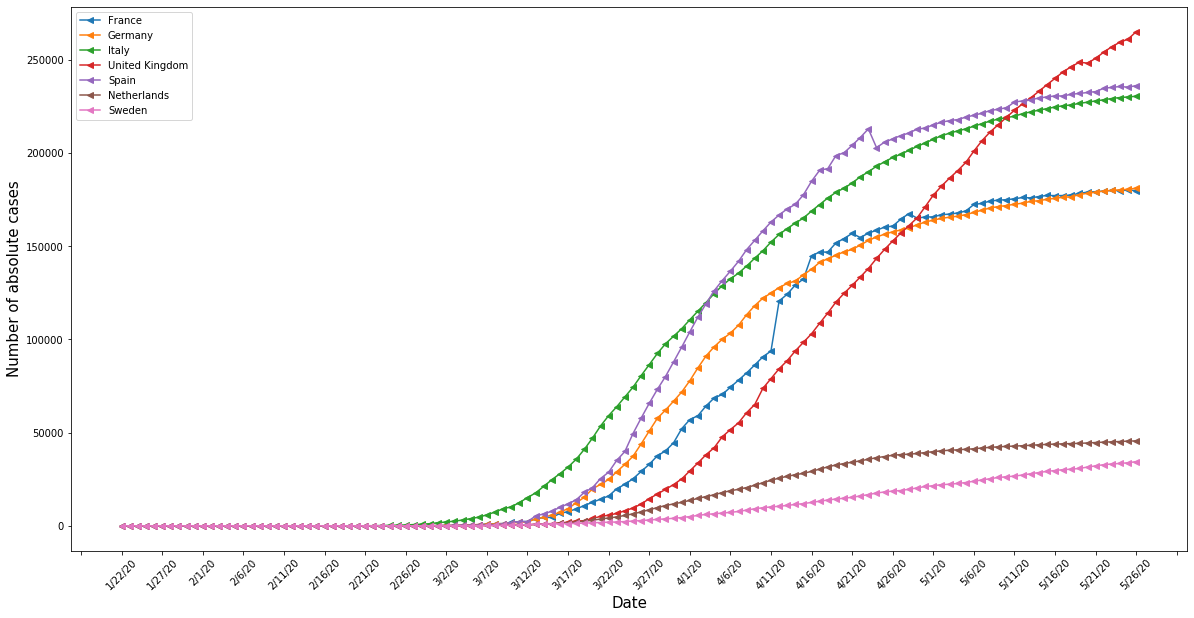

In [13]:
list_countries = ['France', 'Germany', 'Italy', 'United Kingdom', 'Spain', 'Netherlands', 'Sweden']

#if 'US_Mainland' in list_countries: list_countries.remove('US_Mainland')
colourList = []
for i in range(0, len(list_countries)+1):
    colourList.append(np.random.rand(3,)) # getcolour()
#labels = ["Increase in number of deaths", "Number of new deaths per day"]
labels = ["Number of absolute cases", "Western Europe"]
filtering = True
Ts = 1 
order = 6  
cutoff = 0.3
filterInputs = [filtering, Ts, order, cutoff]
plotDailyChanges(cases_sum_df, list_countries, colourList, labels, filterInputs, plotAbsoluteCases = True)

In [22]:
conf_df[conf_df['Country/Region'] == 'Australia'].head(10)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20
8,Australian Capital Territory,Australia,-35.4735,149.0124,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,2,3,4,6,9,19,32,39,39,53,62,71,77,78,80,84,87,91,93,96,96,96,99,100,103,103,103,102,103,103,103,103,103,103,104,104,104,104,105,106,106,106,106,106,106,106,106,106,107,107,107,107,107,107,107,107,107,107,107,107,107,107,107,107,107,107,107,107,107,107,107
9,New South Wales,Australia,-33.8688,151.2093,0,0,0,0,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,6,6,13,22,22,26,28,38,48,55,65,65,92,112,134,171,210,267,307,353,436,669,669,818,1029,1219,1405,1617,1791,2032,2032,2182,2298,2389,2493,2580,2637,2686,2734,2773,2822,2857,2857,2863,2870,2886,2897,2926,2936,2957,2963,2969,2971,2976,2982,2994,3002,3004,3016,3016,3025,3030,3035,3033,3035,3042,3044,3047,3051,3053,3053,3053,3059,3063,3071,3074,3075,3076,3078,3081,3082,3084,3086,3087,3090,3092,3089
10,Northern Territory,Australia,-12.4634,130.8456,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,1,1,1,1,1,1,1,1,3,3,5,5,6,6,12,12,15,15,15,17,19,21,22,26,27,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,27,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29
11,Queensland,Australia,-28.0167,153.4000,0,0,0,0,0,0,0,1,3,2,3,2,2,3,3,4,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,9,9,9,11,11,13,13,13,15,15,18,20,20,35,46,61,68,78,94,144,184,221,259,319,397,443,493,555,625,656,689,743,781,835,873,900,907,921,934,943,953,965,974,983,987,998,999,1001,1007,1015,1019,1019,1024,1024,1026,1026,1026,1030,1033,1034,1033,1033,1034,1035,1038,1043,1043,1045,1045,1045,1045,1045,1051,1052,1051,1054,1055,1055,1057,1057,1058,1058,1058,1060,1061,1056,1057,1058
12,South Australia,Australia,-34.9285,138.6007,0,0,0,0,0,0,0,0,0,0,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,5,5,7,7,7,7,7,9,9,16,19,20,29,29,37,42,50,67,100,134,170,170,235,257,287,299,305,337,367,367,396,407,407,411,411,415,420,428,429,429,429,433,433,433,435,435,435,435,437,438,438,438,438,438,438,438,438,438,438,438,438,438,438,438,439,439,439,439,439,439,439,439,439,439,439,439,439,439,439,439,439,439,439,440
13,Tasmania,Australia,-41.4545,145.9707,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,2,2,2,3,3,5,5,6,7,7,10,10,10,16,22,28,28,36,47,47,62,66,66,69,69,72,74,80,82,86,89,98,111,122,133,133,144,165,165,169,180,188,195,200,201,205,207,207,207,212,214,218,219,221,221,221,221,221,225,226,227,227,227,227,227,227,227,227,228,228,228,228,228,228,228,228,228,228,228,228
14,Victoria,Australia,-37.8136,144.9631,0,0,0,0,1,1,1,1,2,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,7,7,9,9,10,10,10,11,11,15,18,21,21,36,49,57,71,94,121,121,121,229,355,355,411,466,520,574,685,769,821,917,968,1036,1085,1115,1135,1158,1191,1212,1228,1241,1265,1268,1281,1291,1299,1299,1302,1319,1328,1329,1336,1336,1337,1343

In [50]:
col_list = conf_df.columns[0:4].tolist()
for col in conf_df.columns[4:]:
    col = '12/14/20'
    print(col)
    if len(col) == 8: 
        col = "Diff_Prev_Day_" + col[3:5] + col[2] + col[0:2] # i.e. '12/12/20'
    elif len(col) == 7:
        col = "Diff_Prev_Day_" + col[2:4] + col[1] + col[0] # i.e. '2/12/20'
    elif len(col) == 6:
        col = "Diff_Prev_Day_" + col[2:3] + col[1] + col[0] # i.e. '2/2/20'
    col_list.append(col)
    print(col)

12/14/20
Diff_Prev_Day_14/12
12/14/20
Diff_Prev_Day_14/12
12/14/20
Diff_Prev_Day_14/12
12/14/20
Diff_Prev_Day_14/12
12/14/20
Diff_Prev_Day_14/12
12/14/20
Diff_Prev_Day_14/12
12/14/20
Diff_Prev_Day_14/12
12/14/20
Diff_Prev_Day_14/12
12/14/20
Diff_Prev_Day_14/12
12/14/20
Diff_Prev_Day_14/12
12/14/20
Diff_Prev_Day_14/12
12/14/20
Diff_Prev_Day_14/12
12/14/20
Diff_Prev_Day_14/12
12/14/20
Diff_Prev_Day_14/12
12/14/20
Diff_Prev_Day_14/12
12/14/20
Diff_Prev_Day_14/12
12/14/20
Diff_Prev_Day_14/12
12/14/20
Diff_Prev_Day_14/12
12/14/20
Diff_Prev_Day_14/12
12/14/20
Diff_Prev_Day_14/12
12/14/20
Diff_Prev_Day_14/12
12/14/20
Diff_Prev_Day_14/12
12/14/20
Diff_Prev_Day_14/12
12/14/20
Diff_Prev_Day_14/12
12/14/20
Diff_Prev_Day_14/12
12/14/20
Diff_Prev_Day_14/12
12/14/20
Diff_Prev_Day_14/12
12/14/20
Diff_Prev_Day_14/12
12/14/20
Diff_Prev_Day_14/12
12/14/20
Diff_Prev_Day_14/12
12/14/20
Diff_Prev_Day_14/12
12/14/20
Diff_Prev_Day_14/12
12/14/20
Diff_Prev_Day_14/12
12/14/20
Diff_Prev_Day_14/12
12/14/20
Diff_

In [43]:
country = 'United Kingdom'
country_df = cases_sum[cases_sum['Country/Region'] == country]
uniqueProvs = country_df['Province/State'].unique()
country_df = country_df[(country_df['Province/State'].isnull()) | (country_df['Province/State'].str.contains('_Total'))]
if len(country_df) > 1:
    #country_df.drop([country + '_Total'], axis = 0, inplace = True)
    country_df = country_df[country_df['Province/State'] != country + '_Total']
country_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20
223,NaN,United Kingdom,55.3781,-3.436,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,3,3,3,8,8,9,9,9,9,9,9,9,9,9,9,9,9,13,13,13,15,20,23,36,40,51,85,115,163,206,273,321,382,456,456,798,1140,1140,1543,1950,2626,2689,3983,5018,5683,6650,8077,9529,11658,14543,17089,19522,22141,25150,29474,33718,38168,41903,47806,51608,55242,60733,65077,73758,78991,84279,88621,93873,98476,103093,108692,114217,120067,124743,129044,133495,138078,143464,148377,152840,157149,161145,165221,171253,177454,182260,186599,190584,194990,201101,206715,211364,215260,219183,223060,226463,229705,233151,236711,240161,243695,246406,248818,248293,250908,254195,257154,259559,261184,265227


In [38]:
cases_sum[cases_sum['Country/Region'] == 'United Kingdom'].head(15)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20
217,Bermuda,United Kingdom,32.307800,-64.750500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,6,6,6,7,15,17,17,22,27,32,32,35,35,35,37,39,39,39,48,48,48,57,57,57,81,81,83,83,86,86,86,99,99,99,109,109,110,110,111,114,114,114,115,115,115,118,118,118,118,118,119,121,121,122,122,123,123,125,125,125,125,128,128,133,133,139
218,Cayman Islands,United Kingdom,19.313300,-81.254600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,3,3,3,5,6,8,8,8,8,8,12,14,22,28,28,35,35,39,45,45,45,45,45,53,53,54,54,60,61,61,61,66,66,66,66,70,70,70,70,70,73,73,74,74,74,75,78,78,80,81,81,81,84,85,86,93,94,94,94,94,111,111,121,129,129,129,134,137
219,Channel Islands,United Kingdom,49.372300,-2.364400,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,2,2,3,6,6,6,11,14,32,32,36,36,46,66,88,97,108,141,141,172,193,232,262,309,323,335,351,361,398,407,431,436,440,447,457,470,484,488,488,496,498,521,523,525,525,525,530,537,537,538,543,544,544,545,545,545,545,545,545,546,547,548,549,549,554,554,555,555,558,558,558,558,558,559,559
220,Gibraltar,United Kingdom,36.140800,-5.353600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,3,8,10,10,10,15,15,15,26,35,55,56,65,69,69,81,88,95,98,103,109,113,120,123,127,129,129,129,129,131,131,132,132,132,132,132,132,133,133,136,141,141,141,141,144,144,144,144,144,144,144,144,146,146,146,147,148,147,147,147,147,147,147,147,149,151,151,152,154,154,154
221,Isle of Man,United Kingdom,54.236100,-4.548100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,5,13,23,23,25,29,32,42,49,60,68,95,114,126,127,139,150,158,190,201,226,228,242,254,256,284,291,297,298,300,307,307,307,308,308,308,308,309,313,315,316,320,321,325,326,327,329,329,329,330,330,331,332,332,334,335,335,335,335,336,336,336,336,336,336,336
222,Montserrat,United Kingdom,16.742500,-62.187400,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,5,5,5,5,5,5,5,5,6,6,6,6,9,9,9,9,9,9,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11
223,NaN,United Kingdom,55.378100,-3.436000,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,3,3,3,8,8,9,9,9,9,9,9,9,9,9,9,9,9,13,13,13,15,20,23,36,40,51,85,115,163,206,273,321,382,456,456,798,1140,1140,1543,1950,2626,2689,3983,5018,5683,6650,8077,9529,11658,14543,17089,19522,22141,25150,29474,33718,38168,41903,47806,51608,55242,60733,65077,73758,78991,84279,88621,93873,98476,103093,108692,114217,120067,124743,129044,133495,138078,143464,148377,152840,157149,161145,165221,171253,177454,182260,186599,190584,194990,201101,206715,211364,215260,219183,223060,226463,229705,233151,236711,240161,243695,246406,248

In [ ]:
list_countries = ['Australia_Total', 'Victoria', 'New South Wales'] #'US_'
list_countries = ['France', 'Germany', 'Italy', 'United Kingdom', 'Spain', 'Netherlands', 'Sweden']

#if 'US_Mainland' in list_countries: list_countries.remove('US_Mainland')
colourList = []
for i in range(0, len(list_countries)+1):
    colourList.append(getcolour())
#labels = ["Increase in number of deaths", "Number of new deaths per day"]
labels = ["Increase in number of deaths", "Western Europe"]
filtering = True
Ts = 1 
order = 6  
cutoff = 0.3
filterInputs = [filtering, Ts, order, cutoff]
plotDailyChanges(df_daily_change_death, list_countries, colourList, labels, filterInputs)

In [16]:
conf_df['Country/Region'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Benin', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Brazil', 'Brunei', 'Bulgaria',
       'Burkina Faso', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Diamond Princess', 'Cuba', 'Cyprus',
       'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador',
       'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon',
       'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala',
       'Guinea', 'Guyana', 'Haiti', 'Holy See', 'Honduras', 'Hungary',
       'Iceland', 'India

In [ ]:
list_countries = ['France_Mainland', 'US_Mainland', 'Italy_Mainland', 'United Kingdom_Mainland', 'Australia_Total', 'Victoria', 'New South Wales', 'Spain_Mainland']
list_countries = ['France', 'Germany', 'Italy', 'United Kingdom', 'Spain', 'Netherlands', 'Sweden']

#if 'US_Mainland' in list_countries: list_countries.remove('US_Mainland')
#list_countries = ['Australia_Total', 'Victoria', 'New South Wales']
colourList = []
for i in range(0, len(list_countries)+1):
    colourList.append(getcolour())
axislabels = ["Increase in number of cases", "Change in new cases per day"]
filtering = True
Ts = 1 
order = 6  
cutoff = 0.25 
filterInputs = [filtering, Ts, order, cutoff]
plotDailyChanges(cases_sum_df, list_countries, colourList, axislabels, filterInputs)

##### 2.4 New-deaths per day

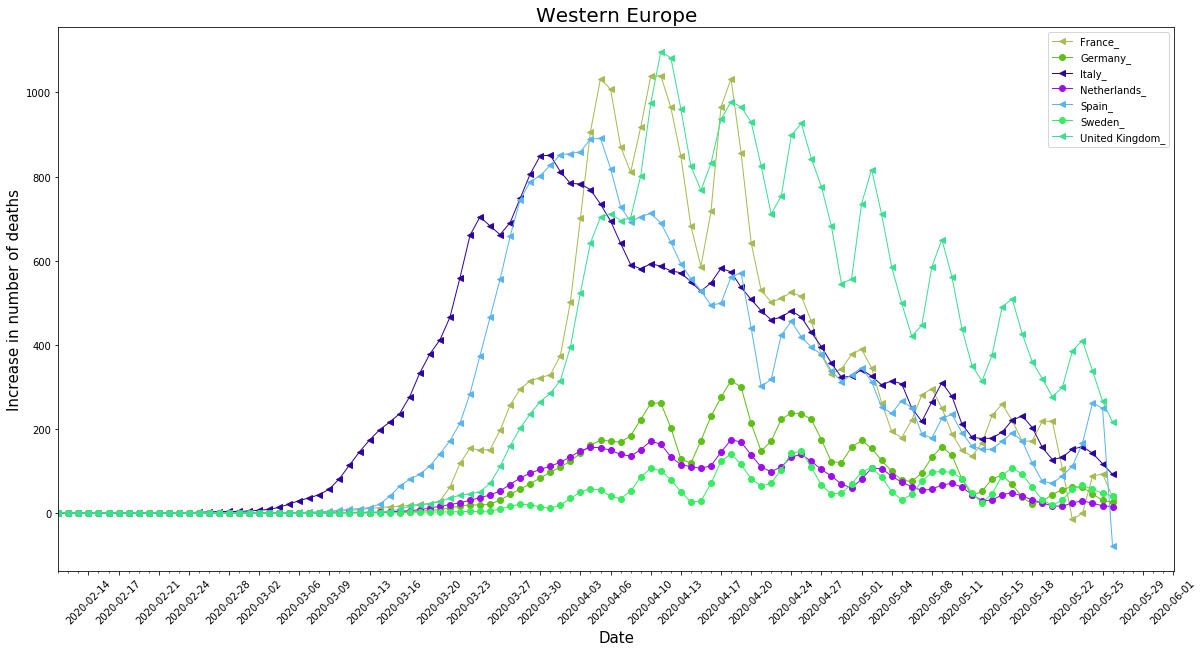

In [11]:
list_countries = ['Australia_Total', 'Victoria', 'New South Wales'] #'US_'
list_countries = ['France_', 'Germany_', 'Italy_', 'United Kingdom_', 'Spain_', 'Netherlands_', 'Sweden_']

#if 'US_Mainland' in list_countries: list_countries.remove('US_Mainland')
colourList = []
for i in range(0, len(list_countries)+1):
    colourList.append(getcolour())
#labels = ["Increase in number of deaths", "Number of new deaths per day"]
labels = ["Increase in number of deaths", "Western Europe"]
filtering = True
Ts = 1 
order = 6  
cutoff = 0.3
filterInputs = [filtering, Ts, order, cutoff]
plotDailyChanges(df_daily_change_death, list_countries, colourList, labels, filterInputs)

#### 3. Number of new-cases per day

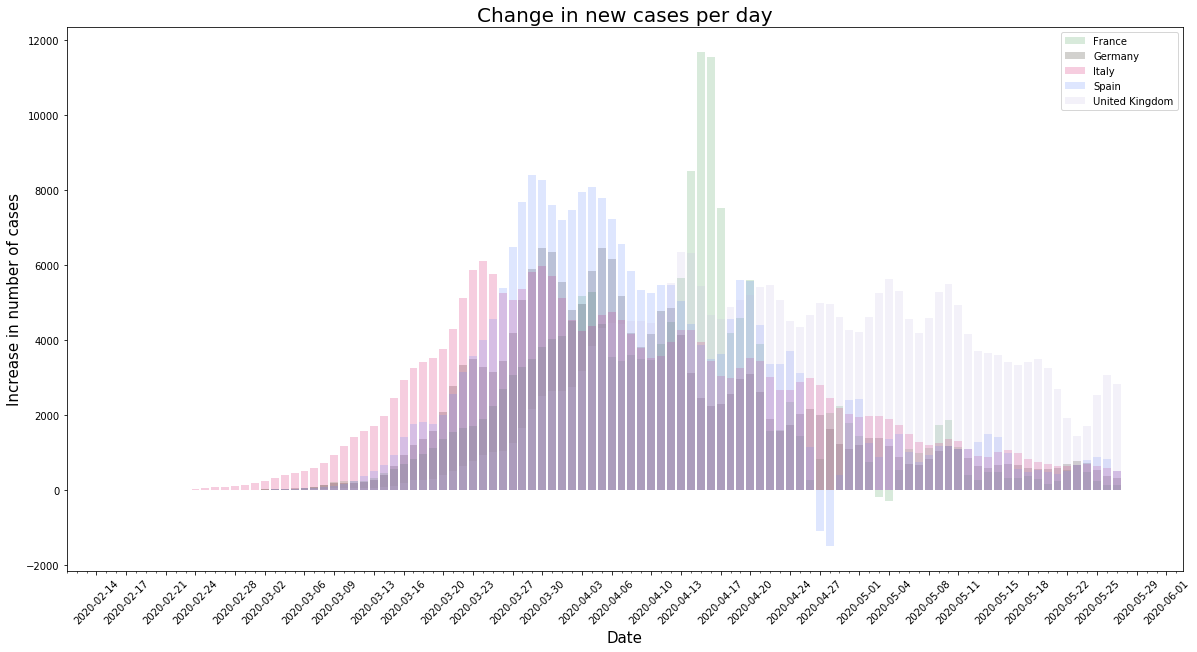

In [109]:
list_countries = ['France_Mainland', 'US_Mainland', 'Italy_Mainland', 'United Kingdom_Mainland', 'Australia_Total', 'Victoria', 'New South Wales', 'Spain_Mainland']
list_countries = ['France', 'Germany', 'Italy', 'United Kingdom', 'Spain']#, 'Netherlands', 'Sweden']
#list_countries = ['Spain']
#if 'US_Mainland' in list_countries: list_countries.remove('US_Mainland')
#list_countries = ['Australia_Total', 'Victoria', 'New South Wales']
colourList = []
for i in range(0, len(list_countries)+1):
    colourList.append(getcolour())
axislabels = ["Increase in number of cases", "Change in new cases per day"]
filtering = True
Ts = 1 
order = 6  
cutoff = 0.25 
filterInputs = [filtering, Ts, order, cutoff]
plotDailyChanges(df_daily_change_conf, list_countries, colourList, axislabels, filterInputs)

In [97]:
df_daily_change_conf[df_daily_change_conf['Province/State'] == 'Spain'].head()


,Province/State,Country/Region,Lat,Long,Diff_Prev_Day_22/1,Diff_Prev_Day_23/1,Diff_Prev_Day_24/1,Diff_Prev_Day_25/1,Diff_Prev_Day_26/1,Diff_Prev_Day_27/1,Diff_Prev_Day_28/1,Diff_Prev_Day_29/1,Diff_Prev_Day_30/1,Diff_Prev_Day_31/1,Diff_Prev_Day_1/2,Diff_Prev_Day_2/2,Diff_Prev_Day_3/2,Diff_Prev_Day_4/2,Diff_Prev_Day_5/2,Diff_Prev_Day_6/2,Diff_Prev_Day_7/2,Diff_Prev_Day_8/2,Diff_Prev_Day_9/2,Diff_Prev_Day_10/2,Diff_Prev_Day_11/2,Diff_Prev_Day_12/2,Diff_Prev_Day_13/2,Diff_Prev_Day_14/2,Diff_Prev_Day_15/2,Diff_Prev_Day_16/2,Diff_Prev_Day_17/2,Diff_Prev_Day_18/2,Diff_Prev_Day_19/2,Diff_Prev_Day_20/2,Diff_Prev_Day_21/2,Diff_Prev_Day_22/2,Diff_Prev_Day_23/2,Diff_Prev_Day_24/2,Diff_Prev_Day_25/2,Diff_Prev_Day_26/2,Diff_Prev_Day_27/2,Diff_Prev_Day_28/2,Diff_Prev_Day_29/2,Diff_Prev_Day_1/3,Diff_Prev_Day_2/3,Diff_Prev_Day_3/3,Diff_Prev_Day_4/3,Diff_Prev_Day_5/3,Diff_Prev_Day_6/3,Diff_Prev_Day_7/3,Diff_Prev_Day_8/3,Diff_Prev_Day_9/3,Diff_Prev_Day_10/3,Diff_Prev_Day_11/3,Diff_Prev_Day_12/3,Diff_Prev_Day_13/3,Diff_Prev_Day_14/3,Diff_Prev_Day_15/3,Diff_Prev_Day_16/3,Diff_Prev_Day_17/3,Diff_Prev_Day_18/3,Diff_Prev_Day_19/3,Diff_Prev_Day_20/3,Diff_Prev_Day_21/3,Diff_Prev_Day_22/3,Diff_Prev_Day_23/3,Diff_Prev_Day_24/3,Diff_Prev_Day_25/3,Diff_Prev_Day_26/3,Diff_Prev_Day_27/3,Diff_Prev_Day_28/3,Diff_Prev_Day_29/3,Diff_Prev_Day_30/3,Diff_Prev_Day_31/3,Diff_Prev_Day_1/4,Diff_Prev_Day_2/4,Diff_Prev_Day_3/4,Diff_Prev_Day_4/4,Diff_Prev_Day_5/4,Diff_Prev_Day_6/4,Diff_Prev_Day_7/4,Diff_Prev_Day_8/4,Diff_Prev_Day_9/4,Diff_Prev_Day_10/4,Diff_Prev_Day_11/4,Diff_Prev_Day_12/4,Diff_Prev_Day_13/4,Diff_Prev_Day_14/4,Diff_Prev_Day_15/4,Diff_Prev_Day_16/4,Diff_Prev_Day_17/4,Diff_Prev_Day_18/4,Diff_Prev_Day_19/4,Diff_Prev_Day_20/4,Diff_Prev_Day_21/4,Diff_Prev_Day_22/4,Diff_Prev_Day_23/4,Diff_Prev_Day_24/4,Diff_Prev_Day_25/4,Diff_Prev_Day_26/4,Diff_Prev_Day_27/4,Diff_Prev_Day_28/4,Diff_Prev_Day_29/4,Diff_Prev_Day_30/4,Diff_Prev_Day_1/5,Diff_Prev_Day_2/5,Diff_Prev_Day_3/5,Diff_Prev_Day_4/5,Diff_Prev_Day_5/5,Diff_Prev_Day_6/5,Diff_Prev_Day_7/5,Diff_Prev_Day_8/5,Diff_Prev_Day_9/5,Diff_Prev_Day_10/5,Diff_Prev_Day_11/5,Diff_Prev_Day_12/5,Diff_Prev_Day_13/5,Diff_Prev_Day_14/5,Diff_Prev_Day_15/5,Diff_Prev_Day_16/5,Diff_Prev_Day_17/5,Diff_Prev_Day_18/5,Diff_Prev_Day_19/5,Diff_Prev_Day_20/5,Diff_Prev_Day_21/5,Diff_Prev_Day_22/5,Diff_Prev_Day_23/5,Diff_Prev_Day_24/5,Diff_Prev_Day_25/5,Diff_Prev_Day_26/5,Diff_Prev_Day_27/5
0,Spain,Spain,40.0,-4.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,7,2,17,13,39,36,45,57,37,141,100,173,400,622,582,0,2955,1159,1407,2144,1806,2162,4053,2447,4964,3394,6368,4749,9630,8271,7933,7516,6875,7846,7967,8195,7947,7134,6969,5478,5029,5267,6278,5002,5051,4754,3804,3268,2442,5103,7304,5891,887,6948,1536,3968,4211,4635,-10034,2915,1729,1831,1308,2144,518,1781,1366,884,545,1318,996,1122,1410,721,772,3086,594,661,849,643,515,0,908,431,518,482,1787,466,482,-372,859,0


In [28]:
df_daily_change_conf.head()

,Province/State,Country/Region,Lat,Long,Diff_Prev_Day_22/1,Diff_Prev_Day_23/1,Diff_Prev_Day_24/1,Diff_Prev_Day_25/1,Diff_Prev_Day_26/1,Diff_Prev_Day_27/1,Diff_Prev_Day_28/1,Diff_Prev_Day_29/1,Diff_Prev_Day_30/1,Diff_Prev_Day_31/1,Diff_Prev_Day_1/2,Diff_Prev_Day_2/2,Diff_Prev_Day_3/2,Diff_Prev_Day_4/2,Diff_Prev_Day_5/2,Diff_Prev_Day_6/2,Diff_Prev_Day_7/2,Diff_Prev_Day_8/2,Diff_Prev_Day_9/2,Diff_Prev_Day_10/2,Diff_Prev_Day_11/2,Diff_Prev_Day_12/2,Diff_Prev_Day_13/2,Diff_Prev_Day_14/2,Diff_Prev_Day_15/2,Diff_Prev_Day_16/2,Diff_Prev_Day_17/2,Diff_Prev_Day_18/2,Diff_Prev_Day_19/2,Diff_Prev_Day_20/2,Diff_Prev_Day_21/2,Diff_Prev_Day_22/2,Diff_Prev_Day_23/2,Diff_Prev_Day_24/2,Diff_Prev_Day_25/2,Diff_Prev_Day_26/2,Diff_Prev_Day_27/2,Diff_Prev_Day_28/2,Diff_Prev_Day_29/2,Diff_Prev_Day_1/3,Diff_Prev_Day_2/3,Diff_Prev_Day_3/3,Diff_Prev_Day_4/3,Diff_Prev_Day_5/3,Diff_Prev_Day_6/3,Diff_Prev_Day_7/3,Diff_Prev_Day_8/3,Diff_Prev_Day_9/3,Diff_Prev_Day_10/3,Diff_Prev_Day_11/3,Diff_Prev_Day_12/3,Diff_Prev_Day_13/3,Diff_Prev_Day_14/3,Diff_Prev_Day_15/3,Diff_Prev_Day_16/3,Diff_Prev_Day_17/3,Diff_Prev_Day_18/3,Diff_Prev_Day_19/3,Diff_Prev_Day_20/3,Diff_Prev_Day_21/3,Diff_Prev_Day_22/3,Diff_Prev_Day_23/3,Diff_Prev_Day_24/3,Diff_Prev_Day_25/3,Diff_Prev_Day_26/3,Diff_Prev_Day_27/3,Diff_Prev_Day_28/3,Diff_Prev_Day_29/3,Diff_Prev_Day_30/3,Diff_Prev_Day_31/3,Diff_Prev_Day_1/4,Diff_Prev_Day_2/4,Diff_Prev_Day_3/4,Diff_Prev_Day_4/4,Diff_Prev_Day_5/4,Diff_Prev_Day_6/4,Diff_Prev_Day_7/4,Diff_Prev_Day_8/4,Diff_Prev_Day_9/4,Diff_Prev_Day_10/4,Diff_Prev_Day_11/4,Diff_Prev_Day_12/4,Diff_Prev_Day_13/4,Diff_Prev_Day_14/4,Diff_Prev_Day_15/4,Diff_Prev_Day_16/4,Diff_Prev_Day_17/4,Diff_Prev_Day_18/4,Diff_Prev_Day_19/4,Diff_Prev_Day_20/4,Diff_Prev_Day_21/4,Diff_Prev_Day_22/4,Diff_Prev_Day_23/4,Diff_Prev_Day_24/4,Diff_Prev_Day_25/4,Diff_Prev_Day_26/4,Diff_Prev_Day_27/4,Diff_Prev_Day_28/4,Diff_Prev_Day_29/4,Diff_Prev_Day_30/4,Diff_Prev_Day_1/5,Diff_Prev_Day_2/5,Diff_Prev_Day_3/5,Diff_Prev_Day_4/5,Diff_Prev_Day_5/5,Diff_Prev_Day_6/5,Diff_Prev_Day_7/5,Diff_Prev_Day_8/5,Diff_Prev_Day_9/5,Diff_Prev_Day_10/5,Diff_Prev_Day_11/5,Diff_Prev_Day_12/5,Diff_Prev_Day_13/5,Diff_Prev_Day_14/5,Diff_Prev_Day_15/5,Diff_Prev_Day_16/5,Diff_Prev_Day_17/5,Diff_Prev_Day_18/5,Diff_Prev_Day_19/5,Diff_Prev_Day_20/5,Diff_Prev_Day_21/5,Diff_Prev_Day_22/5,Diff_Prev_Day_23/5,Diff_Prev_Day_24/5,Diff_Prev_Day_25/5
0,Afghanistan_Mainland,Afghanistan,33.0000,65.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,2.0,0.0,0.0,4.0,5.0,5.0,1.0,0.0,0.0,2.0,0.0,16.0,0.0,34.0,10.0,10.0,16.0,0.0,10.0,50.0,4.0,63.0,36.0,8.0,18.0,50.0,18.0,56.0,21.0,40.0,37.0,34.0,52.0,58.0,49.0,70.0,56.0,66.0,27.0,63.0,30.0,66.0,84.0,103.0,72.0,112.0,68.0,172.0,125.0,111.0,232.0,164.0,134.0,235.0,190.0,330.0,168.0,171.0,215.0,255.0,369.0,285.0,276.0,263,413,414,349,262,408,581,492,531,540,782,584,591
0,Afghanistan_Total,Afghanistan,33.0000,65.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,2.0,0.0,0.0,4.0,5.0,5.0,1.0,0.0,0.0,2.0,0.0,16.0,0.0,34.0,10.0,10.0,16.0,0.0,10.0,50.0,4.0,63.0,36.0,8.0,18.0,50.0,18.0,56.0,21.0,40.0,37.0,34.0,52.0,58.0,49.0,70.0,56.0,66.0,27.0,63.0,30.0,66.0,84.0,103.0,72.0,112.0,68.0,172.0,125.0,111.0,232.0,164.0,134.0,235.0,190.0,330.0,168.0,171.0,215.0,255.0,369.0,285.0,276.0,263,413,414,349,262,408,581,492,531,540,782,584,591
0,Albania_Mainland,Albania,41.1533,20.1683,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2.0,11.0,10.0,5.0,4.0,9.0,4.0,4.0,5.0,6.0,6.0,13.0,15.0,19.0,23.0,28.0,12.0,11.0,15.0,11.0,20.0,16.0,18.0,27.0,29.0,28.0,16.0,6.0,17.0,9.0,7.0,17.0,13.